# SI 670: Applied Machine Learning. HW 8 - Deep Learning
## Due 11:59pm, 12/02

In this assignment, we'll build a simple CNN to detect a *smile* in an image. The data is given in the 'datasets.zip'. If you are using Colab, you should run the cell below to load the data. If you are using Jupyter Notebook, you should unzip the file for later use.

In [1]:
%tensorflow_version 1.x
import tensorflow as tf
import keras
keras.__version__
import warnings
warnings.filterwarnings('ignore')

TensorFlow 1.x selected.


Using TensorFlow backend.


In [2]:
# run this cell if you are using Colab

!rm -rf datasets.zip
!rm -rf datasets

import io

from google.colab import files as colab_files
uploaded = colab_files.upload()

!unzip datasets.zip

Streaming output truncated to the last 5000 lines.
  inflating: datasets/train_folder/0/file2454.jpg  
  inflating: __MACOSX/datasets/train_folder/0/._file2454.jpg  
  inflating: datasets/train_folder/0/file2369.jpg  
  inflating: __MACOSX/datasets/train_folder/0/._file2369.jpg  
  inflating: datasets/train_folder/0/file3077.jpg  
  inflating: __MACOSX/datasets/train_folder/0/._file3077.jpg  
  inflating: datasets/train_folder/0/file3063.jpg  
  inflating: __MACOSX/datasets/train_folder/0/._file3063.jpg  
  inflating: datasets/train_folder/0/file2355.jpg  
  inflating: __MACOSX/datasets/train_folder/0/._file2355.jpg  
  inflating: datasets/train_folder/0/file2433.jpg  
  inflating: __MACOSX/datasets/train_folder/0/._file2433.jpg  
  inflating: datasets/train_folder/0/file2427.jpg  
  inflating: __MACOSX/datasets/train_folder/0/._file2427.jpg  
  inflating: datasets/train_folder/0/file2341.jpg  
  inflating: __MACOSX/datasets/train_folder/0/._file2341.jpg  
  inflating: datasets/train_f

## Question 1 (20 points)

First, you need to build data generators to pre-process the data.

Please build a *train_generator* and a *validation_generator* that rescale all the images by 1./255. The images should be resized with size (32, 32). Set the batch_size to 50 and the class_mode as 'binary'. The *train_generator* should take data from the directory 'datasets/train_folder' and the *validation_generator* should take data from the directory 'datasets/test_folder'. 



In [3]:
train_dir = './datasets/train_folder'
validation_dir= './datasets/test_folder'

In [4]:
from keras.preprocessing.image import ImageDataGenerator


# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 32x32
        target_size=(32, 32),
        batch_size=50,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(32, 32),
        batch_size=50,
        class_mode='binary')


Found 2800 images belonging to 2 classes.
Found 1200 images belonging to 2 classes.


data batch shape: (50, 32, 32, 3)
labels batch shape: (50,)


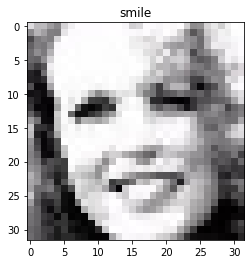

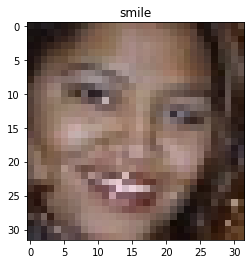

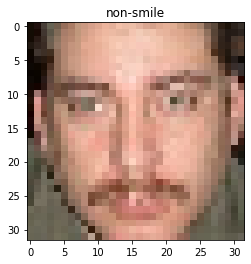

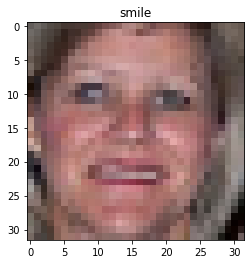

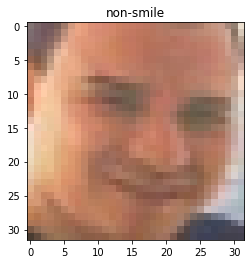

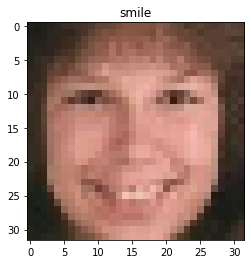

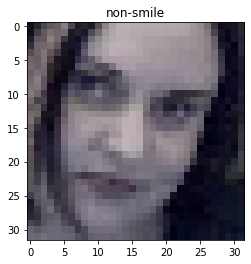

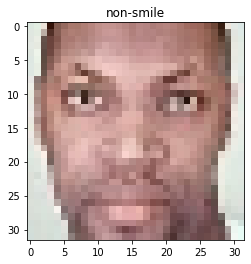

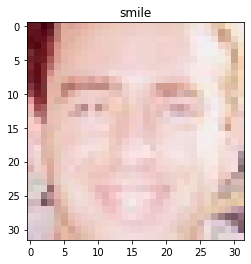

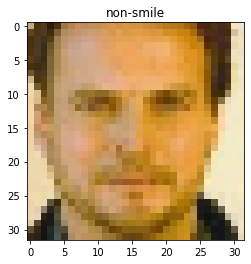

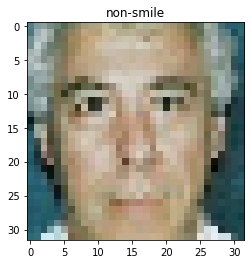

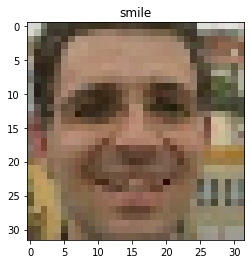

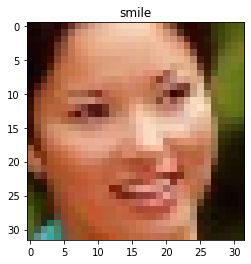

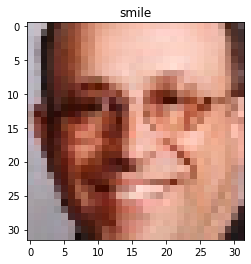

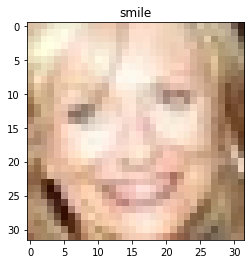

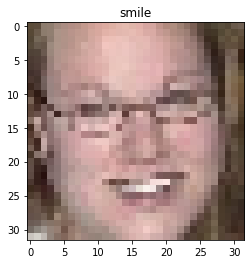

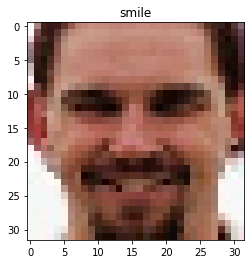

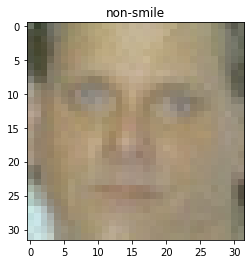

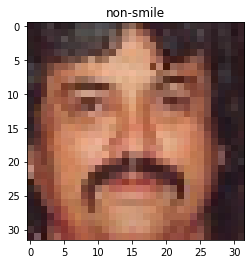

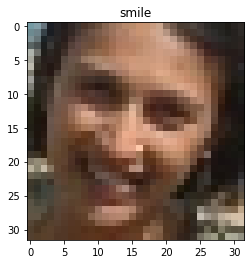

In [5]:
# You can verify whether your data generator looks good by using this code
# The data is not perfect so don't be suprised if you see some non-faces :)
%matplotlib inline
from matplotlib import pyplot as plt
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    for i in range(20):
        plt.figure()
        plt.imshow(data_batch[i])
        if labels_batch[i] == 1:
            plt.title('smile')
        else:
            plt.title('non-smile')
    break

## Question 2 (20 points)

Let's build the model using Keras - we want a sequential model.

The first layer is a convolutional layer. Use *Conv2D* with $32$ filters, kernel size $(3,3)$ and *relu* as activation. You also need to specify the input shape since it is the first layer. Here we want input shape to be $(32\times32\times3)$. 

The second layer is the same as the first one, except that we don't need to specify input shape here.

The third layer is *MaxPooling2D* layer with *pool_size* to be $(2,2)$.

The fouth layer is *Dropout* layer with dropout rate 0.25.

Then we need a *Flatten* layer to change the shape of features.

Then a *Dense* layer with output dimension $128$ and *relu* as the activation.

Then a *Dropout* layer with dropout rate 0.5.

Finally a *Dense* layer with output dimension $1$, which are the labels, and *sigmoid* as the activation.

Here are some useful links: https://keras.io/layers/convolutional/#conv2d, https://keras.io/layers/pooling/#maxpooling2d, https://keras.io/layers/core/#dropout, https://keras.io/layers/core/#flatten, https://keras.io/layers/core/#dense

You can use *model.summary()* to see a summary of your model.

In [6]:
from keras import models,layers
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D

#Model
model = models.Sequential()

#Layer 1 
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(32, 32, 3)))
#Layer 2
model.add(layers.Conv2D(32, (3, 3), activation='relu'))

#Layer 3
model.add(layers.MaxPooling2D((2, 2)))

#Layer 4
model.add(layers.Dropout(.25))

#Flatten
model.add(layers.Flatten())

#Layer 5
model.add(layers.Dense(128, activation='relu'))

#Layer 6
model.add(layers.Dropout(.5))

#Layer 7
model.add(layers.Dense(1, activation='sigmoid'))

#Summary
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               802944    
______________________________________

## Question 3 (20 points) 

Now we'll train the model.

First you need to specify the loss function and the optimizer to be used for model training. Please use the 'binary_corssentropy' loss and 'RMSprop' optimizer with lr=1e-4. You also need to specify the metric to be used for evaluation. In this case please use the 'acc' metric.

Then use *model.fit_generator()* to fit the model with steps_per_epoch=100, epochs=100, and validation_steps=50.

In [8]:
from keras import optimizers
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

model.fit_generator(train_generator,
                    steps_per_epoch=100,
                    epochs=100, 
                    validation_data=validation_generator,
                    validation_steps=50) 

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/100
100/100 [==============================] - 5s 55ms/step - loss: 0.6610 - acc: 0.6034 - val_loss: 0.6809 - val_acc: 0.5496
Epoch 2/100
100/100 [==============================] - 3s 29ms/step - loss: 0.6010 - acc: 0.6844 - val_loss: 0.6312 - val_acc: 0.6668
Epoch 3/100
100/100 [==============================] - 3s 30ms/step - loss: 0.5533 - acc: 0.7350 - val_loss: 0.4297 - val_acc: 0.7428
Epoch 4/100
100/100 [==============================] - 3s 29ms/step - loss: 0.4971 - acc: 0.7768 - val_loss: 0.5312 - val_acc: 0.8064
Epoch 5/100
100/100 [==============================] - 3s 29ms/step - loss: 0.4594 - acc: 0.7964 - val_loss: 0.4673 - val_acc: 0.8064
Epoch 6/100
100/100 [==============================] - 3s 30ms/step - loss: 0.4180 - acc: 0.8182 - val_loss: 0.4647 - val_acc: 0.8204
Epoch 7/100
100/100 [==============================] - 3s 29ms/step - loss: 0.4049 - acc: 0.8254 - va

## Question 4 (20 points) 

Finally we'll have some inspections on the model.

### (a) (10 points)

Use the history data in model to see the accuracy and loss curves (in a single figure) for both training and validation data. https://keras.io/visualization/#training-history-visualization



In [9]:
model.history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

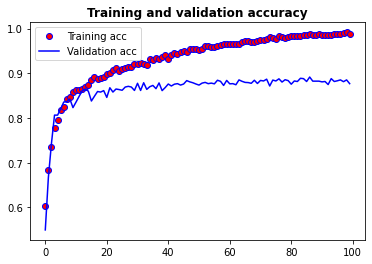

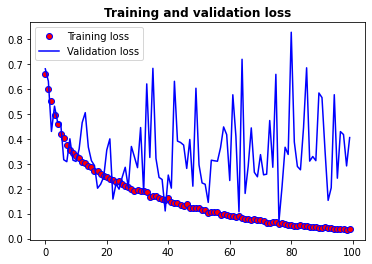

In [18]:
import matplotlib.pyplot as plt

acc = model.history.history['acc']
val_acc = model.history.history['val_acc']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc', markerfacecolor='red')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', fontweight="bold")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss',markerfacecolor='red')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', fontweight="bold")
plt.legend()

plt.show()

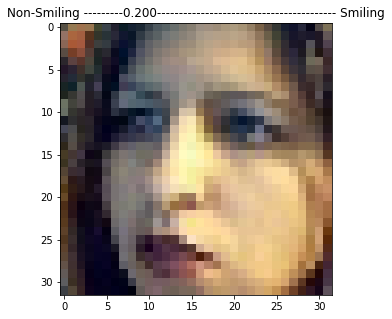

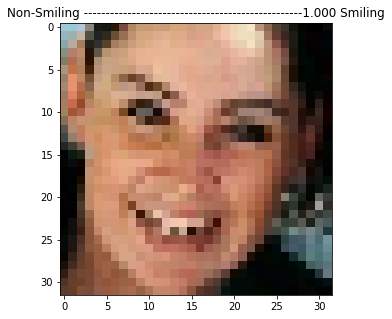

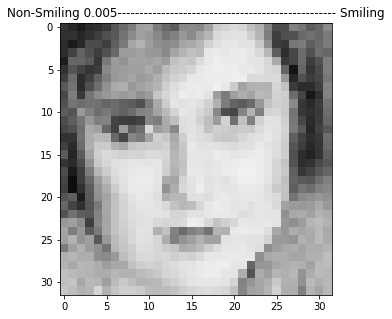

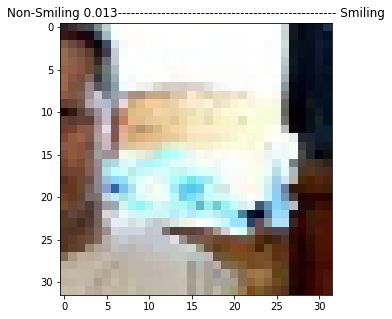

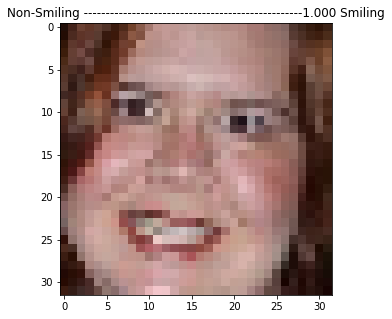

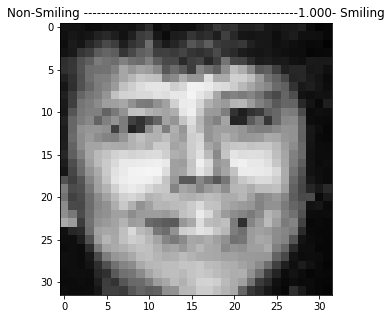

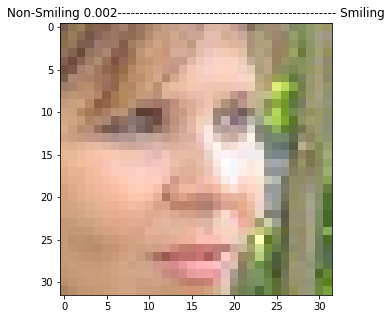

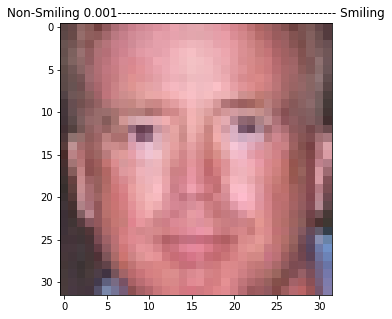

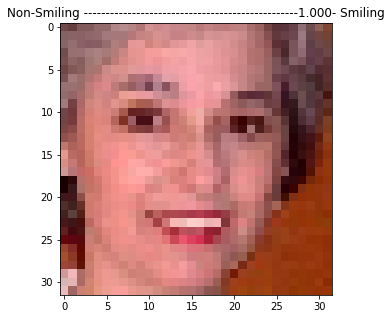

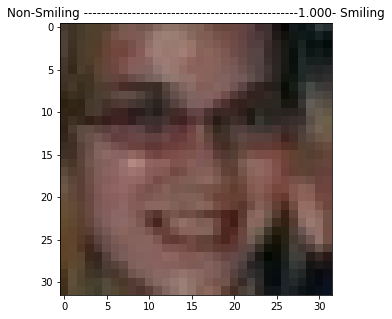

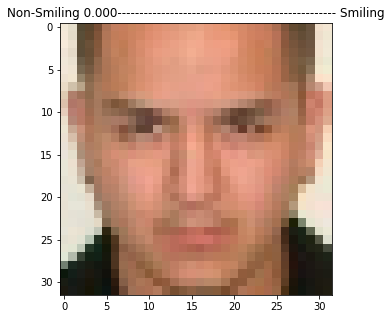

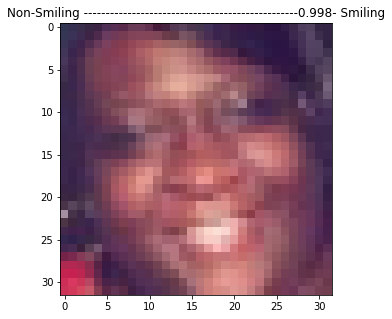

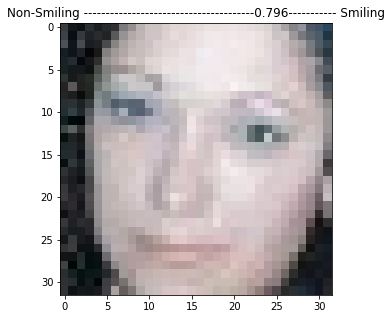

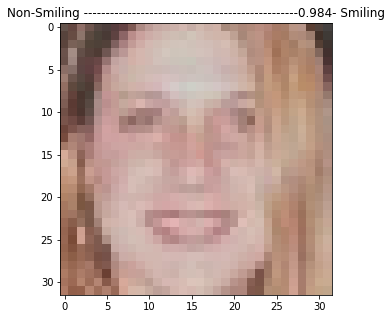

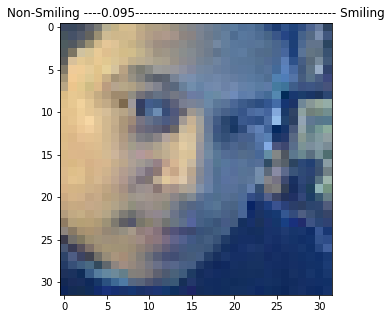

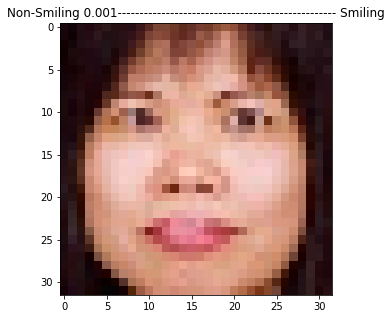

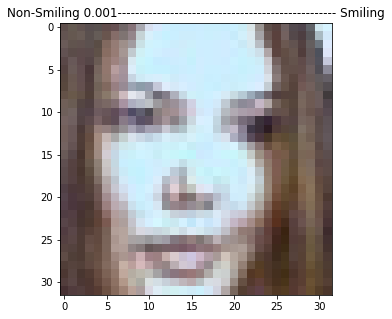

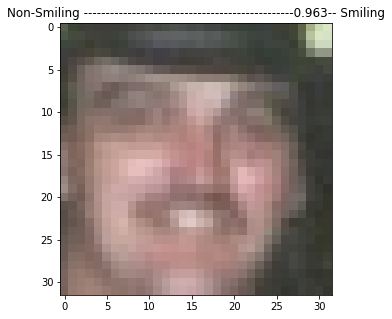

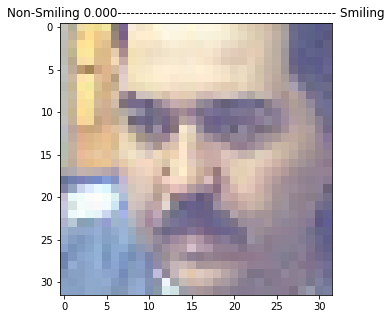

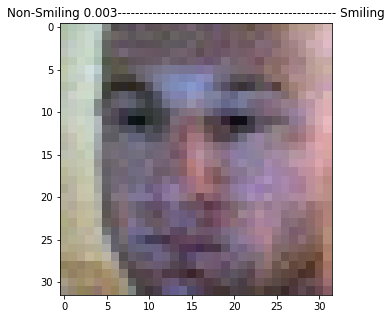

In [19]:
# # You can use this code to check the label for each image
import numpy as np
def print_indicator(data, model, class_names, bar_width=50):
    plt.figure(figsize=(5,5))
    plt.imshow(data)
    probabilities = model.predict(np.array([data]))[0]
    left_count = int(probabilities[0] * bar_width)
    right_count = bar_width - left_count
    left_side = '-' * left_count
    right_side = '-' * right_count
    plt.title(class_names[0] + ' ' + left_side + '%.3f' % probabilities[0] + right_side + ' ' + class_names[1])

from matplotlib import pyplot as plt

for data_batch, labels_batch in validation_generator:
    for i in range(20):
        img = data_batch[i] 
        print_indicator(img, model, ['Non-Smiling', 'Smiling'])
    break

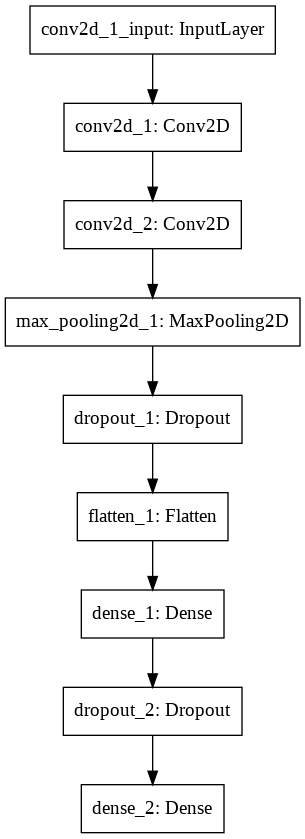

In [17]:
#Model structure (from link in description?) 
tf.keras.utils.plot_model(model)

### (b) (10 points)
Try changing the all the 'relu' activations to 'tanh' of your previous model and repeat the training in Q3. 

In [20]:
#Model
model = models.Sequential()

#Layer 1 
model.add(layers.Conv2D(32, (3, 3), activation='tanh',
                        input_shape=(32, 32, 3)))
#Layer 2
model.add(layers.Conv2D(32, (3, 3), activation='tanh'))

#Layer 3
model.add(layers.MaxPooling2D((2, 2)))

#Layer 4
model.add(layers.Dropout(.25))

#Flatten
model.add(layers.Flatten())

#Layer 5
model.add(layers.Dense(128, activation='tanh'))

#Layer 6
model.add(layers.Dropout(.5))

#Layer 7
model.add(layers.Dense(1, activation='sigmoid'))

#Summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               802944    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)              

In [21]:
from keras import optimizers
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

model.fit_generator(train_generator,
                    steps_per_epoch=100,
                    epochs=100, 
                    validation_data=validation_generator,
                    validation_steps=50) 

Epoch 1/100
100/100 [==============================] - 3s 33ms/step - loss: 0.6496 - acc: 0.6300 - val_loss: 0.6048 - val_acc: 0.7408
Epoch 2/100
100/100 [==============================] - 3s 30ms/step - loss: 0.5260 - acc: 0.7714 - val_loss: 0.5310 - val_acc: 0.7864
Epoch 3/100
100/100 [==============================] - 3s 31ms/step - loss: 0.4332 - acc: 0.8150 - val_loss: 0.4636 - val_acc: 0.8108
Epoch 4/100
100/100 [==============================] - 3s 31ms/step - loss: 0.3848 - acc: 0.8374 - val_loss: 0.4110 - val_acc: 0.8368
Epoch 5/100
100/100 [==============================] - 3s 29ms/step - loss: 0.3563 - acc: 0.8518 - val_loss: 0.3911 - val_acc: 0.8428
Epoch 6/100
100/100 [==============================] - 3s 31ms/step - loss: 0.3270 - acc: 0.8668 - val_loss: 0.3416 - val_acc: 0.8468
Epoch 7/100
100/100 [==============================] - 3s 31ms/step - loss: 0.3120 - acc: 0.8726 - val_loss: 0.2476 - val_acc: 0.8416
Epoch 8/100
100/100 [==============================] - 3s 30ms

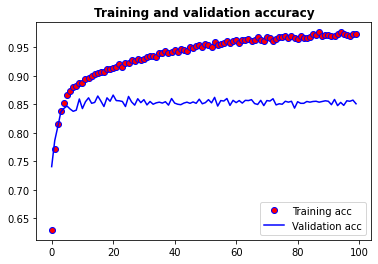

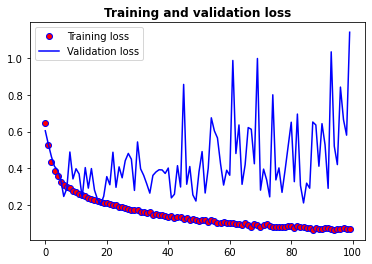

In [22]:
import matplotlib.pyplot as plt

acc = model.history.history['acc']
val_acc = model.history.history['val_acc']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc', markerfacecolor='red')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', fontweight="bold")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss',markerfacecolor='red')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', fontweight="bold")
plt.legend()

plt.show()